# Melbourne Housing Market - Linear Regression (Part 2)

Summary

In this notebook, I will adding on a few additional analyses from the previous notebook of applying linear regression to model price with the various variables. I have included 3 types of feature selection process - Correlation Statistics, Mutual Information Statistics and K-fold Cross Validation - to determine the best number of variables that could improve the model. 

The main components of this notebook can be split into:

1. Continuation from the previous notebook
2. Feature Selection using Correlation Statistics
3. Feature Selection using Mutual Information Statistics.
4. Model Evaluation using MAE, MSE, RMSE and R^2

*This notebook is copied and adapted from https://www.kaggle.com/anthonypino/price-analysis-and-linear-regression. 


## From Part 1

In [60]:
## Import libraries

# Data wrangling
import pandas as pd
import numpy as np
from datetime import date # Usage: Determine days from start

# Data Visualisations
%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

# Model Development and Evaluation
from sklearn.model_selection import train_test_split # For Model Development
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [62]:
# Reading source files

# df_houseprice = pd.read_csv("data/MELBOURNE_HOUSE_PRICES_LESS.csv")
df_housingfull= pd.read_csv("data/Melbourne_housing_FULL.csv")

### 1. Data Cleaning

1. Convert arguments in Date column to datetime
2. Filter out data that are not housing types

In [63]:
# Data Cleaning
df_housingfull = df_housingfull.rename(columns={'Lattitude':'Latitude'}) # Rename column names

# Remove unrelevant column data
df_housingfull = df_housingfull.drop(['Suburb', 'Address', 'SellerG','Regionname', 'CouncilArea'],axis=1)

# Convert date column to datetime
df_housingfull['Date'] = pd.to_datetime(df_housingfull['Date'],dayfirst=True)
print("There are {} rows and {} columns in this dataframe" .format(df_housingfull.shape[0],df_housingfull.shape[1]))

# Create new dataframe with only housing data
df = df_housingfull[df_housingfull['Type']=='h']
print("After filtering data that are not housing types, there are {} rows and {} columns in this new dataframe" .format(df.shape[0],df.shape[1]))

There are 34857 rows and 16 columns in this dataframe
After filtering data that are not housing types, there are 23980 rows and 16 columns in this new dataframe


### 2. Data Exploration using Visualisations

1. Histogram plot for each variable
2. Pair plots 
3. Observe average price change per quarter over the years


Text(0.5, 1.0, 'Price vs Distance')

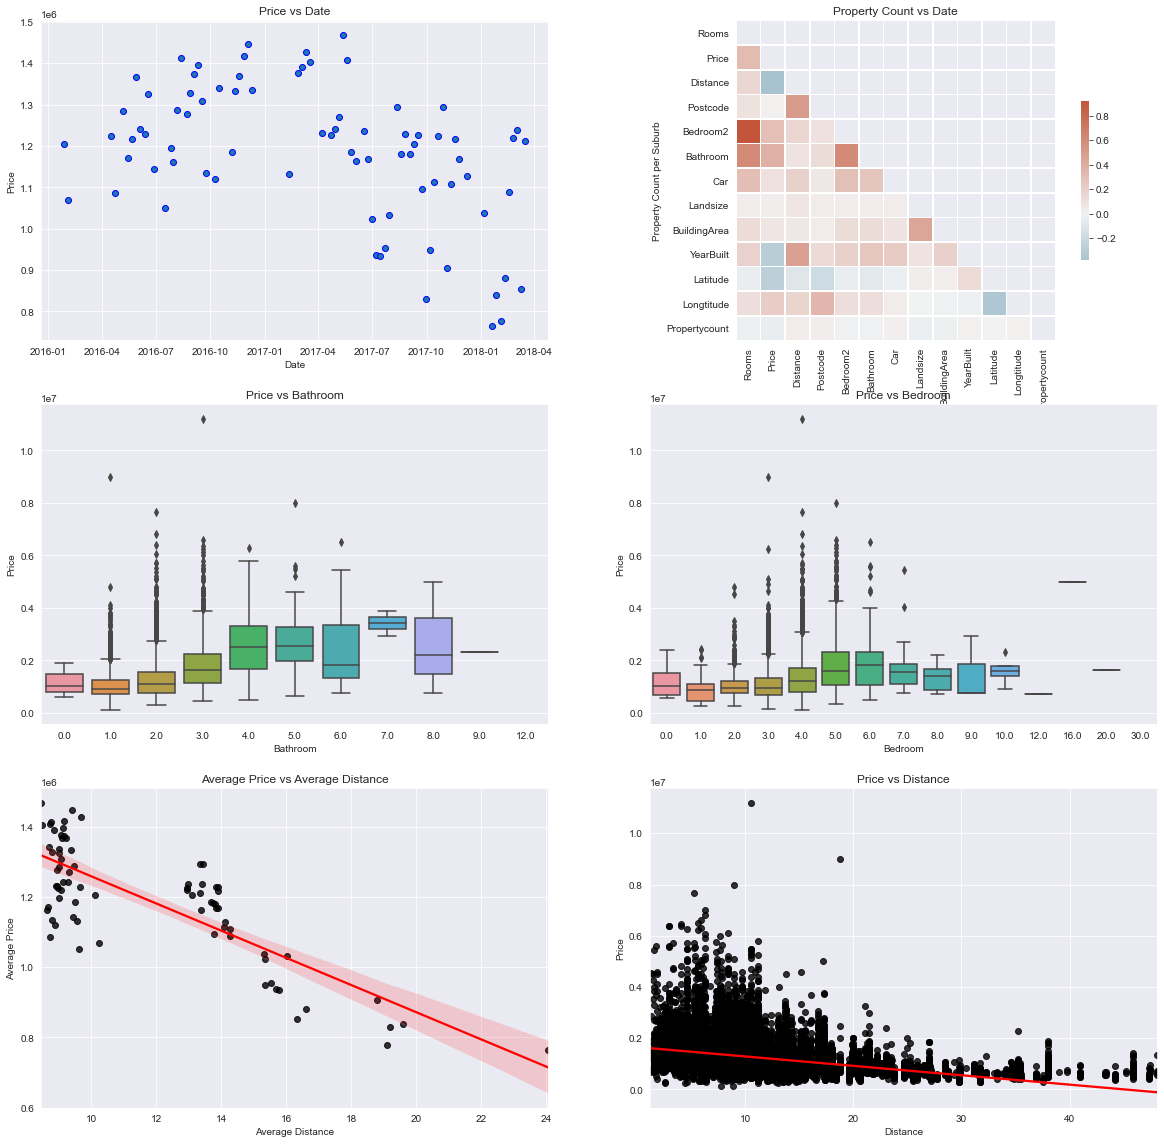

In [20]:
# Plot Relationships between price and features
sns.set_style( 'darkgrid' )
fig, axes = plt.subplots(3,2,figsize=[20,20])

# Plot 1: Scatterplot of AVerage Price against Date
mean_df = df.sort_values('Date',ascending=False).groupby('Date').mean().reset_index()
axes[0,0].scatter(x='Date',y='Price',data=mean_df,edgecolor='b' )
axes[0,0].set_xlabel( 'Date' )
axes[0,0].set_ylabel( 'Price' )
axes[0,0].set_title( 'Price vs Date')

# Plot 2: Diagonal Correlation Matrix 
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=axes[0,1])
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Property Count per Suburb')
axes[0,1].set_title('Property Count vs Date')

# Plot 3: Boxplot of Price against number of Bathrooms
sns.boxplot(x='Bathroom',y='Price',data=df ,ax=axes[1,0] )
axes[1,0].set_xlabel( 'Bathroom' )
axes[1,0].set_ylabel( 'Price' )
axes[1,0].set_title( 'Price vs Bathroom')

# Plot 4: Boxplot of Price against number of Bedrooms
sns.boxplot(x='Bedroom2',y='Price',data=df ,ax=axes[1,1] )
axes[1,1].set_xlabel( 'Bedroom' )
axes[1,1].set_ylabel( 'Price' )
axes[1,1].set_title( 'Price vs Bedroom')

# Plot 5: Regression plot of Average Distance against Average Price
sns.regplot(x='Distance',y='Price',data=mean_df,scatter_kws={"color": "black"}, line_kws={"color": "red"},ax=axes[2,0])
axes[2,0].set_xlabel('Average Distance')
axes[2,0].set_ylabel('Average Price')
axes[2,0].set_title('Average Price vs Average Distance')

# Plot 6: Regression plot of Distance against Price
sns.regplot(x='Distance',y='Price',data=df,scatter_kws={"color": "black"}, line_kws={"color": "red"},ax=axes[2,1])
axes[2,1].set_xlabel('Distance')
axes[2,1].set_ylabel('Price')
axes[2,1].set_title('Price vs Distance')


Analysis:

1. The housing prices in Melbourne appears to begin cooling off sometime between April and July in 2017. 
2. Based on the correlation matrix, the top 2 features that affects pricing is the number of Bathrooms, nunber of Bedrooms and distance (kilometres) from CBD. I plotted boxplots to visualise how price varies the number of bedrooms and bathrooms. The boxplot for the number of bedrooms indicate that there's quite alot of variability. For distance, I used a regression plot to see how price varies. The plot shows a negative relationship between the two, which is logical since housing near CBD are usually priced higher than those in the outer regions.

### 3. Linear Regression Model with all Features

In this part, I will evaluate the linear regression model using all the available features. The data is split into training and test data with a 2:1 ratio. The coefficient for each predictor variable is subsequently ranked after, showing that longitude, number of bathrooms and the vendor bid method as the top 3 most significant feature in the model. 



In [21]:
## Further data cleanup
# Remove missing values
df1 = df.dropna().sort_values('Date')

###########
##Find out days since start
days_since_start = [(x-df1['Date'].min()).days for x in df1['Date']]
df1['Days'] = days_since_start

# Convert Categorical Variables to dummy/indicator variables
df2_dummies = pd.get_dummies(df1[['Type','Method']])
df2 = df1.drop(['Type','Date','Method'],axis=1).join(df2_dummies)

# Determine x (independent variables or predictor variables) and y (dependent variables) 
y = df2['Price'] # Price being the dependent variable
x = df2.drop(['Price'],axis=1) # Remove price from the independent variables

# Split into training and test set
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)

# Fit the model
model = LinearRegression()
model.fit(x_train,y_train)

# Evalute the model
ypredictions = model.predict(x_test)

# Ranking the coefficients
coeff_df = pd.DataFrame(model.coef_,x.columns,columns=['Coefficient'])
ranked_coeff = coeff_df.sort_values("Coefficient", ascending = False)
print(ranked_coeff)

                Coefficient
Longtitude     6.086180e+05
Bathroom       2.399838e+05
Rooms          1.061976e+05
Method_VB      5.120039e+04
Car            4.855776e+04
Method_S       2.623847e+04
Bedroom2       4.899668e+03
BuildingArea   1.524659e+03
Postcode       9.823297e+02
Days           9.843806e+01
Landsize       7.213708e+01
Propertycount  1.014999e-01
Type_h        -1.746230e-10
YearBuilt     -3.400507e+03
Method_PI     -1.607145e+04
Method_SA     -2.740480e+04
Method_SP     -3.396260e+04
Distance      -5.107843e+04
Latitude      -1.468303e+06


### 4. Visualising Regression Models

Text(0.5, 1.0, 'Observed vs Predicted')

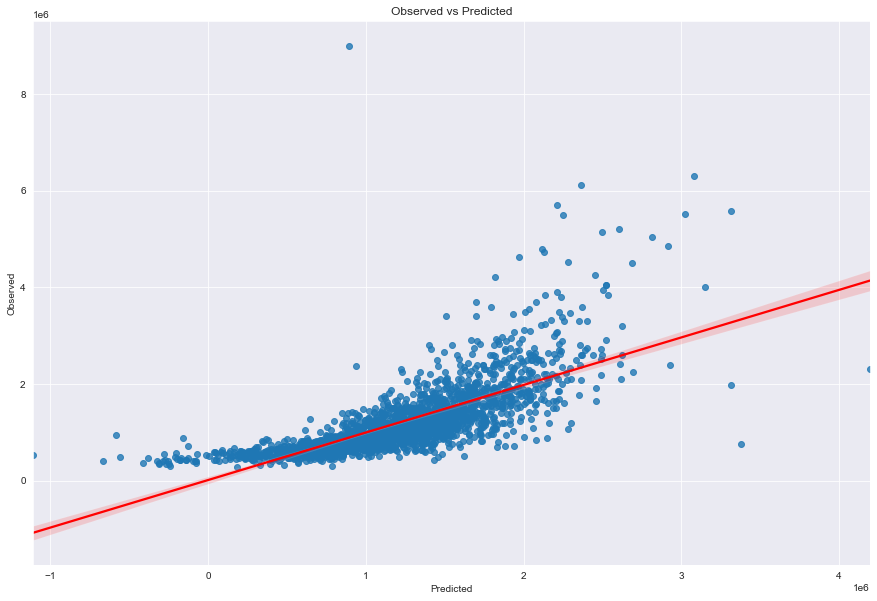

In [22]:
fig_lm,axes_lm = plt.subplots(1,1,figsize=[15,10]) # Create a custom size figure

# # ax1 = fig_lm.add_subplot() # Add subplot
sns.regplot(x=ypredictions,y=y_test,line_kws={"color":"red"},ax=axes_lm)
axes_lm.set_xlabel("Predicted") # Add x label
axes_lm.set_ylabel("Observed") # Add y label
axes_lm.set_title("Observed vs Predicted")

Distribution plot: difference in actual price and predicted price

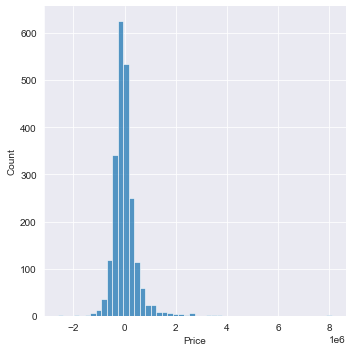

In [23]:
sns.displot(data=(y_test-ypredictions),bins=50)

(End of Part 1)

## Part 2 - Feature Selection 

In [28]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV

### Mutual Information Statistics

This model leverages on the correlation (most common correlation measure being pearsons correlation) to determine which variable is the most relevant.



In [32]:
# Create a function that can implement feature selection for the input training and test data
def select_features_mis(X_train,Y_train, X_test):
    # Configure to select all features
    features = SelectKBest(score_func=mutual_info_regression, k = 16)
    # Learn relationship from training data
    features.fit(X_train,Y_train)
    # Transform training data
    X_train_feats = features.transform(X_train)
    # Transorm test data
    X_test_feats = features.transform(X_test)
    return X_train_feats,X_test_feats,features

# Running the regression model that applies feature selection (mutual information statistics)
# Feature selection
x_train_feats_mis, x_test_feats_mis, features_mis = select_features_mis(x_train,y_train,x_test)

# Scores for the features
for feature in range(len(features_mis.scores_)):
    print('Feature %d: %f' % (feature, features_mis.scores_[feature]))

# Fit the model
model_feats_mis = LinearRegression()
model_feats_mis.fit(x_train_feats_mis,y_train)

# Evaluate the model
ypredictions_feats_mis = model_feats_mis.predict(x_test_feats_mis)

Feature 0: 0.085276
Feature 1: 0.379063
Feature 2: 0.535257
Feature 3: 0.083888
Feature 4: 0.111936
Feature 5: 0.028387
Feature 6: 0.061553
Feature 7: 0.143656
Feature 8: 0.147641
Feature 9: 0.300453
Feature 10: 0.259006
Feature 11: 0.328668
Feature 12: 0.039872
Feature 13: 0.011723
Feature 14: 0.014065
Feature 15: 0.040096
Feature 16: 0.000000
Feature 17: 0.005040
Feature 18: 0.056839


### Correlation Statistics

This model leverages on the correlation (most common correlation measure being pearsons correlation) to determine which variable is the most relevant.

In [48]:
# Create a function that can implement feature selection for the input training and test data
def select_features_cs(X_train,Y_train, X_test):
    # Configure to select all features
    features = SelectKBest(score_func=f_regression, k = 16)
    # Learn relationship from training data
    features.fit(X_train,Y_train)
    # Transform training data
    X_train_feats = features.transform(X_train)
    # Transorm test data
    X_test_feats = features.transform(X_test)
    return X_train_feats,X_test_feats,features

# Running the regression model that applies feature selection (correlation statistics)
# Feature selection
x_train_feats_cs, x_test_feats_cs, features_cs = select_features_cs(x_train,y_train,x_test)

# Scores for the features
for feature in range(len(features_cs.scores_)):
    print('Feature %d: %f' % (feature, features_cs.scores_[feature]))

# Create model
model_feats_cs = LinearRegression()
# Fit the model
model_feats_cs.fit(x_train_feats_cs,y_train)
# Evaluate the model
ypredictions_feats_cs = model_feats_cs.predict(x_test_feats_cs)

Feature 0: 624.218533
Feature 1: 831.558520
Feature 2: 1.104028
Feature 3: 559.223771
Feature 4: 1039.871719
Feature 5: 52.724016
Feature 6: 6.962535
Feature 7: 918.872851
Feature 8: 354.376184
Feature 9: 356.552179
Feature 10: 228.442479
Feature 11: 11.192402
Feature 12: 75.345978
Feature 13: nan
Feature 14: 18.467231
Feature 15: 15.835652
Feature 16: 0.421705
Feature 17: 54.838265
Feature 18: 118.419765


### Visualising Regression Models

Text(0.5, 1.0, 'Linear Regression: Correlation Statistics for Observed vs Predicted')

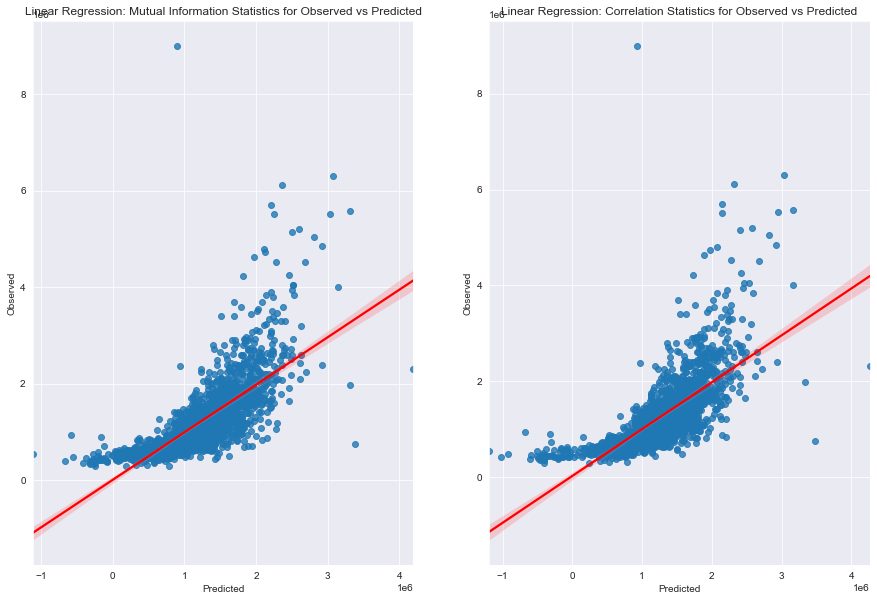

In [46]:
fig_lm,(axes_lm_mis,axes_lm_cs) = plt.subplots(1,2,figsize=[15,10]) # Create a custom size figure

# Creating plot for Mutual Information Statistics
sns.regplot(x=ypredictions_feats_mis,y=y_test,line_kws={"color":"red"},ax=axes_lm_mis)
axes_lm_mis.set_xlabel("Predicted") # Add x label
axes_lm_mis.set_ylabel("Observed") # Add y label
axes_lm_mis.set_title("Linear Regression: Mutual Information Statistics for Observed vs Predicted")

# Creating plot for Correlation Statistics
sns.regplot(x=ypredictions_feats_cs,y=y_test,line_kws={"color":"red"},ax=axes_lm_cs)
axes_lm_cs.set_xlabel("Predicted") # Add x label
axes_lm_cs.set_ylabel("Observed") # Add y label
axes_lm_cs.set_title("Linear Regression: Correlation Statistics for Observed vs Predicted")

### Model Evaluation

In [58]:
print("------Evaluated predictions for a raw Linear Regression Model------")
print("MAE: ", metrics.mean_absolute_error(y_test,ypredictions))
print("MSE: ", metrics.mean_squared_error(y_test,ypredictions))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test,ypredictions)))
print("R^2: ", metrics.r2_score(y_test,ypredictions))

print("------Evaluated predictions for a Linear Regression Model with Correlation Statistics Feature Selection------")
print("MAE: ", metrics.mean_absolute_error(y_test,ypredictions_feats_cs))
print("MSE: ", metrics.mean_squared_error(y_test,ypredictions_feats_cs))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test,ypredictions_feats_cs)))
print("R^2: ", metrics.r2_score(y_test,ypredictions_feats_cs))

print("------Evaluated predictions for a Linear Regression Model with Mutual Information Statistics Feature Selection------")
print("MAE: ", metrics.mean_absolute_error(y_test,ypredictions_feats_mis))
print("MSE: ", metrics.mean_squared_error(y_test,ypredictions_feats_mis))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test,ypredictions_feats_mis)))
print("R^2: ", metrics.r2_score(y_test,ypredictions_feats_mis))


------Evaluated predictions for a raw Linear Regression Model------
MAE:  301077.07816341706
MSE:  235171170575.45062
RMSE:  484944.50257266616
R^2:  0.5415862801118618
------Evaluated predictions for a Linear Regression Model with Correlation Statistics Feature Selection------
MAE:  309316.00912912446
MSE:  246586130384.74255
RMSE:  496574.39561937
R^2:  0.5193353631489246
------Evaluated predictions for a Linear Regression Model with Mutual Information Statistics Feature Selection------
MAE:  301072.41752915125
MSE:  235167756102.42468
RMSE:  484940.9820817629
R^2:  0.541592935865105


By applying two types of feature selection techniques and comparing the models, the metrics indicate that mutual information statistics allow us to to achieve a more accurate model - higher R^2 and lower error metrics (MAE, MSE and RMSE).